In [1]:
#@title Get model coordinates
import plotly.express as px
import pandas as pd
import numpy as np

coor = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Coron/met_ model/distan_lat42.58lon-8.8046p3R4Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

In [2]:
#@title Get station sample accumulated rain hour before

#Load station. Delete duplicated and resample with sum
station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Coron/station_data/prec_o.csv", usecols = ["time","prec_o"],parse_dates=["time"]).set_index("time")
station = station[~station.index.duplicated(keep='first')]
station = station.resample("H",label="right",closed="right").sum()

#label and display climatology
interval = pd.IntervalIndex.from_tuples([(-0.5,0.1), (0.1, 40)])
labels=['No Rain', 'Rain']
station["prec_o_l"] = pd.cut(station["prec_o"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
station = station.drop(["prec_o"],axis=1)
display((station["prec_o_l"].value_counts(normalize=True)*100).map('{:.0f}%'.format))




No Rain    88%
Rain       12%
Name: prec_o_l, dtype: object

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41975 entries, 2018-01-01 01:00:00 to 2022-12-30 23:00:00
Data columns (total 76 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   prec_o_l     41975 non-null  category
 1   dir0         41975 non-null  float64 
 2   snow_prec0   41975 non-null  float64 
 3   snowlevel0   41975 non-null  float64 
 4   mod0         41975 non-null  float64 
 5   wind_gust0   41975 non-null  float64 
 6   mslp0        41975 non-null  float64 
 7   temp0        41975 non-null  float64 
 8   rh0          41975 non-null  float64 
 9   visibility0  41975 non-null  float64 
 10  lhflx0       41975 non-null  float64 
 11  lwflx0       41975 non-null  float64 
 12  conv_prec0   41975 non-null  float64 
 13  prec0        41975 non-null  float64 
 14  swflx0       41975 non-null  float64 
 15  shflx0       41975 non-null  float64 
 16  cape0        41975 non-null  float64 
 17  cin0         41975 non-null  float

None

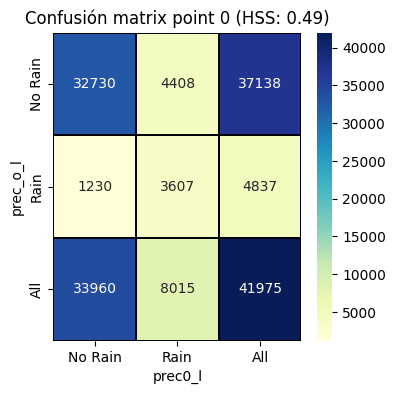

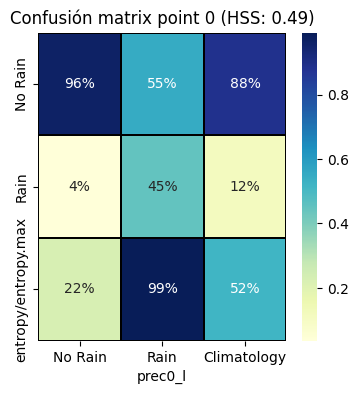

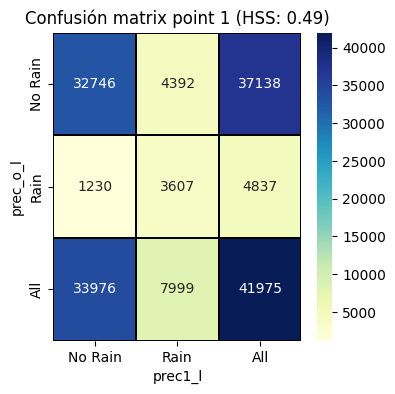

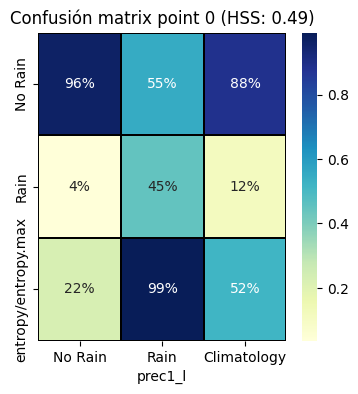

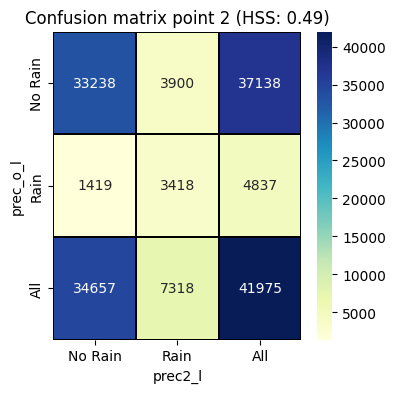

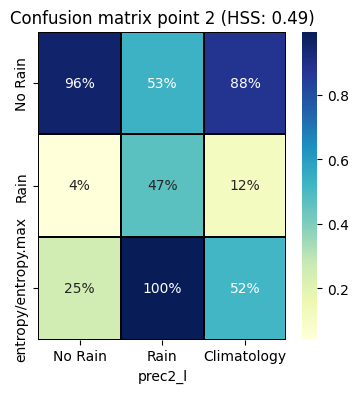

In [3]:
#@title Get meteorologic model d0. Compare (with Heidke skill score) meteorological model variables prec0, prec1 and prec2 versus prec_o_l from the station

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import math
from scipy.stats import entropy
import seaborn as sns

def HSS(y_true,y_pred):
  """
  Heidke skill score
  """
  cm = pd.crosstab(y_true, y_pred)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  hss = 2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d))
  return round(hss,2)


#Load d0. Concatenate and dropna
met_model = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Coron/met_ model/lat42.58lon-8.8046p3R4KmD0.csv",parse_dates=["time"]).drop(columns=["Unnamed: 0"]).set_index("time")
df_all = pd.concat([station,met_model],axis=1).dropna()
display(df_all.info())


#label dir 0,1 and 2
df_all["prec0_l"] = pd.cut(df_all["prec0"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
df_all["prec1_l"] = pd.cut(df_all["prec1"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
df_all["prec2_l"] = pd.cut(df_all["prec2"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')

hss0 = HSS(df_all.prec_o_l, df_all.prec0_l)
hss1 = HSS(df_all.prec_o_l, df_all.prec1_l)
hss2 = HSS(df_all.prec_o_l, df_all.prec2_l)
#best hss
hss_met = hss0

#point 0
plt.figure(figsize=(4, 4))
plt.title("Confusión matrix point 0 (HSS: {})".format(hss0))
global_sc = pd.crosstab(df_all.prec_o_l, df_all.prec0_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');


plt.figure(figsize=(4, 4))
plt.title("Confusión matrix point 0 (HSS: {})".format(hss0))
column_sc = pd.crosstab(df_all.prec_o_l, df_all.prec0_l, margins=True,normalize="columns")
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
columns_entro = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(columns_entro,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

#point1
plt.figure(figsize=(4, 4))
plt.title("Confusión matrix point 1 (HSS: {})".format(hss1))
global_sc = pd.crosstab(df_all.prec_o_l, df_all.prec1_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

plt.figure(figsize=(4, 4))
plt.title("Confusión matrix point 0 (HSS: {})".format(hss1))
column_sc = pd.crosstab(df_all.prec_o_l, df_all.prec1_l, margins=True,normalize="columns")
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
columns_entro = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(columns_entro,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');


#point2
plt.figure(figsize=(4, 4))
plt.title("Confusion matrix point 2 (HSS: {})".format(hss2))
global_sc = pd.crosstab(df_all.prec_o_l, df_all.prec2_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

plt.figure(figsize=(4, 4))
plt.title("Confusion matrix point 2 (HSS: {})".format(hss2))
column_sc = pd.crosstab(df_all.prec_o_l, df_all.prec2_l, margins=True,normalize="columns")
entro = pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T
columns_entro = pd.concat([column_sc,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(columns_entro,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

#delete met model label columns
df_all = df_all.drop(["prec0_l","prec1_l","prec2_l"],axis=1)


machine learning number: 0
machine learning number: 1
machine learning number: 2
machine learning number: 3
machine learning number: 4
machine learning number: 5
machine learning number: 6
machine learning number: 7
machine learning number: 8
machine learning number: 9
HSS [0.52, 0.55, 0.51, 0.52, 0.57, 0.54, 0.54, 0.57, 0.55, 0.53]
Accuracy Machine learning models


,HSS
count,10.000000
mean,0.540000
std,0.020548
min,0.510000
25%,0.522500
50%,0.540000
75%,0.550000
max,0.570000


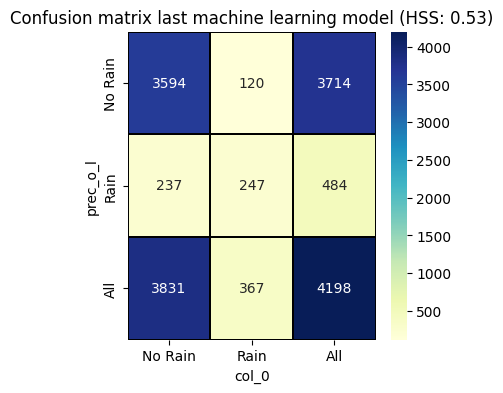

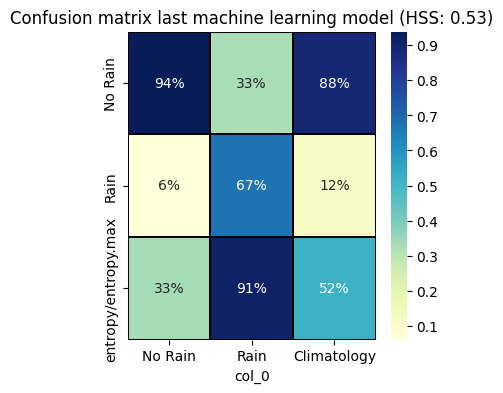

In [4]:
#@title Add time variables. Train LGBMClassifier. Show machine learning results last split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#numpy randomseed
np.random.seed(1)

# target variable
Y = df_all.prec_o_l
X = df_all[["prec0","visibility0","mod0","dir0","prec1","mod1","dir1","prec2",
            "mod2","dir2","hour","month","dayofyear","weekofyear"]]
X = df_all[df_all.columns[1:]]

HSS_t = []
for t in range (0,10):
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1,stratify=Y )
  ml_model = LGBMClassifier(n_estimators=200,verbose=0,force_col_wise=True).fit(X_train,y_train)
  #ml_model = ExtraTreesClassifier(n_estimators=200).fit(X_train,y_train)
  y_pred = ml_model.predict(X_test)
  HSS_t.append(HSS(y_test,y_pred))
  print("machine learning number:",t)

print("HSS",HSS_t)
print("Accuracy Machine learning models")
df_r=pd.DataFrame({"HSS":HSS_t,});
display(df_r.describe())

#Show machine learning results
plt.figure(figsize=(4, 4))
plt.title("Confusion matrix last machine learning model (HSS: {})".format(HSS_t[-1]))
global_sc_ml = pd.crosstab(y_test, y_pred, margins=True,)
sns.heatmap(global_sc_ml[global_sc.columns],annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');


plt.figure(figsize=(4, 4))
plt.title("Confusion matrix last machine learning model (HSS: {})".format(HSS_t[-1]))
column_sc_ml = pd.crosstab(y_test, y_pred, margins=True,normalize="columns")
entro = pd.DataFrame(entropy(column_sc_ml,base=2)/(math.log2(column_sc_ml.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc_ml.columns).T
columns_entro = pd.concat([column_sc_ml,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(columns_entro,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

In [5]:
#@title Save algorithm
import pickle
from sklearn.pipeline import Pipeline
score ={"hss_met":hss_met,"hss_ml":HSS_t[-1]}

estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)
print(pipe)
al_file={"x_var":X.columns,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/Coron/algorithms/prec_coron_d0.al", 'wb'))

Pipeline(steps=[('ml_model',
                 LGBMClassifier(force_col_wise=True, n_estimators=200,
                                verbose=0))])


machine learning number: 0
machine learning number: 1
machine learning number: 2
machine learning number: 3
machine learning number: 4
machine learning number: 5
machine learning number: 6
machine learning number: 7
machine learning number: 8
machine learning number: 9
HSS [0.54, 0.56, 0.5, 0.57, 0.54, 0.54, 0.53, 0.52, 0.57, 0.56]
Accuracy Machine learning models


,HSS
count,10.000000
mean,0.543000
std,0.022632
min,0.500000
25%,0.532500
50%,0.540000
75%,0.560000
max,0.570000


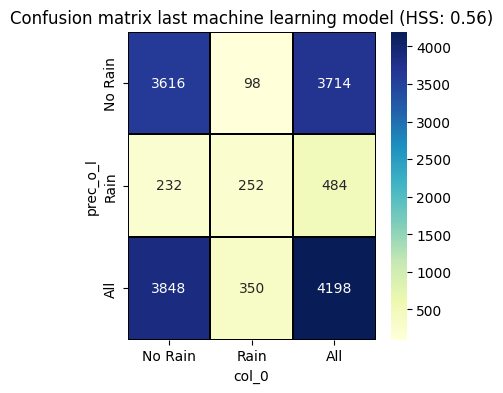

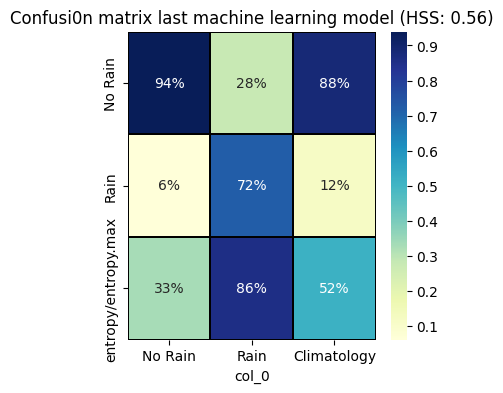

In [6]:
#@title Add time variables. Train LGBMClassifier. Show machine learning results last split

#numpy randomseed
np.random.seed(1)

# target variable
Y = df_all.prec_o_l
X = df_all[["prec0","visibility0","mod0","dir0","prec1","mod1","dir1","prec2",
            "mod2","dir2","hour","month","dayofyear","weekofyear"]]
X = df_all[df_all.columns[1:]]

HSS_extra = []
for t in range (0,10):
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1,stratify=Y )
  #ml_model = LGBMClassifier(n_estimators=200,verbose=0,force_col_wise=True).fit(X_train,y_train)
  ml_model = ExtraTreesClassifier(n_estimators=250).fit(X_train,y_train)
  y_pred = ml_model.predict(X_test)
  HSS_extra.append(HSS(y_test,y_pred))
  print("machine learning number:",t)

print("HSS",HSS_extra)
print("Accuracy Machine learning models")
df_r=pd.DataFrame({"HSS":HSS_extra,});
display(df_r.describe())

#Show machine learning results
plt.figure(figsize=(4, 4))
plt.title("Confusion matrix last machine learning model (HSS: {})".format(HSS_extra[-1]))
global_sc_ml = pd.crosstab(y_test, y_pred, margins=True,)
sns.heatmap(global_sc_ml[global_sc.columns],annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');


plt.figure(figsize=(4, 4))
plt.title("Confusi0n matrix last machine learning model (HSS: {})".format(HSS_extra[-1]))
column_sc_ml = pd.crosstab(y_test, y_pred, margins=True,normalize="columns")
entro = pd.DataFrame(entropy(column_sc_ml,base=2)/(math.log2(column_sc_ml.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc_ml.columns).T
columns_entro = pd.concat([column_sc_ml,entro]).rename(columns={"All":"Climatology"})
sns.heatmap(columns_entro,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

In [7]:
# @title T test two related samples. This is a test for the null hypothesis that two related samples have identical accuracy. Alternative hypothesis the accuracy from the sample with extratrees is more than the accuracy with lgbm. Significance level (alpha) = 0.05
from scipy import stats

alpha = 0.05
sta, p_value = stats.ttest_rel( HSS_extra, HSS_t , alternative="greater")

print("\nHSS Lgbm:",HSS_t )
print("\nHSS extratrees:", HSS_extra)
print("\nalpha: ",alpha)
print("\np_value point: ",p_value)

if p_value < alpha:
    print("\nwe are rejecting null hypothesis  H0: HSS lgbm less than  HSS extratrees")

else:
    print("\nwe are accepting null hypothesis: H0: HSS lgbm = HSS extratrees")



HSS Lgbm: [0.52, 0.55, 0.51, 0.52, 0.57, 0.54, 0.54, 0.57, 0.55, 0.53]

HSS extratrees: [0.54, 0.56, 0.5, 0.57, 0.54, 0.54, 0.53, 0.52, 0.57, 0.56]

alpha:  0.05

p_value point:  0.37738642130355216

we are accepting null hypothesis: H0: HSS lgbm = HSS extratrees
